# Final project deliverable 1 

In this project we will use the bloodwork results of individuals to train a model that can predict the cause of anemia in an individual. 

Being able to quickly (and hopefully accurately) diagnose an individual's condition based on medical test results in the real world could save lives. By directing patients to the treatment they need faster and earlier we could treat some conditions at an earlier stage where the patient is more likely to survive. 

For this project we have 2 goals:

1. understand the underlying structure of our data, whether through visualizations or through various metrics
2. use both supervised learning and unsupervised learning to predict the diagnosis based on bloodwork results. 

In this case I will try both supervised and unsupervised models and compare their performances. 

Our data for this project comes from this source. 

https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification

The github repository link is: 

https://github.com/yiliu7724/5510-final

## download and install needed packages

For this project I will need to use a stats package called pingouin to run ANOVA. Here is the documentation to this package:

https://pingouin-stats.org/build/html/index.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pylab as plt 

In [2]:
pip install pingouin

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Import data

So Let's start with importing the data

In [4]:
raw = pd.read_csv("diagnosed_cbc_data_v4.csv")

## Data Understanding

Let's start with a few visualizations for understanding what exactly we are dealing with:

In [5]:
raw.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


In [6]:
raw.shape

(1281, 15)

We can see that our data has 1281 data points. with 15 columns. The last column is the label/ground truth. And the other columns are the features. 

In [7]:
print(raw.dtypes)

WBC          float64
LYMp         float64
NEUTp        float64
LYMn         float64
NEUTn        float64
RBC          float64
HGB          float64
HCT          float64
MCV          float64
MCH          float64
MCHC         float64
PLT          float64
PDW          float64
PCT          float64
Diagnosis     object
dtype: object


Looks like all of our features are intergers. Cool

In [8]:
raw.Diagnosis.unique()

array(['Normocytic hypochromic anemia', 'Iron deficiency anemia',
       'Other microcytic anemia', 'Leukemia', 'Healthy',
       'Thrombocytopenia', 'Normocytic normochromic anemia',
       'Leukemia with thrombocytopenia', 'Macrocytic anemia'],
      dtype=object)

In [9]:
len(raw.Diagnosis.unique())

9

Our ground truth has 9 different labels. These labels are nonordinal, meaning they can't be ordered. 

So we should treat these 9 as separate classes. In supervides learning this would be a multi-class calssification problem. 

Let's do some histograms and correlation analysis of the features first. 

#### Summary

For this dataset we have 1281 total cases, with 15 features. 

Only diagnosis is of an object type. All the rest of the features are numeric. 

Our data contains the ground truth, this allows us to compare our unsupervised models with the supervised models. It also allows us to use metrics such as AUC and confusion matrix and stuff to decide how well our models are working. 

The data here is from one source. 

## Data Cleaning

In [10]:
 cleaned = raw.copy()

### Cleck for missing values

Let's start my checking if the dataset has any missing values

In [11]:
cleaned.isna().sum()

WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64

Looks like we actually don't have any missing values. 

### Check for outliers/errors/anomalies

Checking for outliers is important if we wish to scale our features, some of these outliers could also be errors during data entry. We should try to identify the really extreme ones and remove them. 

<Axes: >

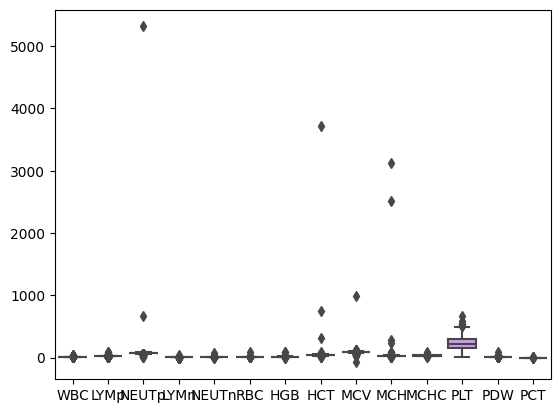

In [12]:
sb.boxplot(cleaned)

Okay we do have some rather strange values based on this plot. 

Our data is not very high dimentional, so we can take more care in removing the outliers. 

Let's create individual botplots to see what are the outliers and remove them:

(If you don't want to look at the exact cleaning steps here I invite you to look at the visualization at the end of this section)

#### WBC

<Axes: >

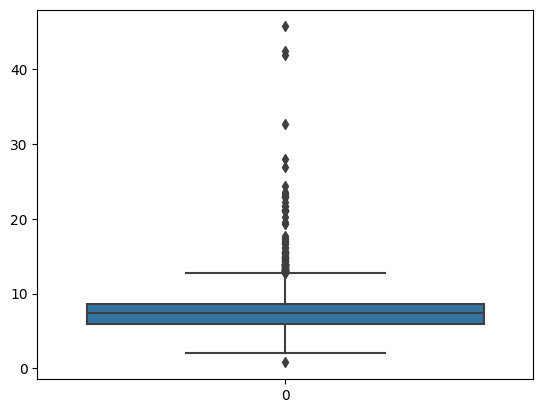

In [13]:
sb.boxplot(cleaned.WBC)

Looks like we don't have good reasons to remove any datapoint based on this feature

#### LYMp

This is the lymphocyte level result. It actually appears to be in percentages. The data source did not have anything on this.  

here is a resource as to its normal ranges:

https://www.verywellhealth.com/what-are-lymphocytes-4140826

Looks like we have nothing to remove here.

<Axes: >

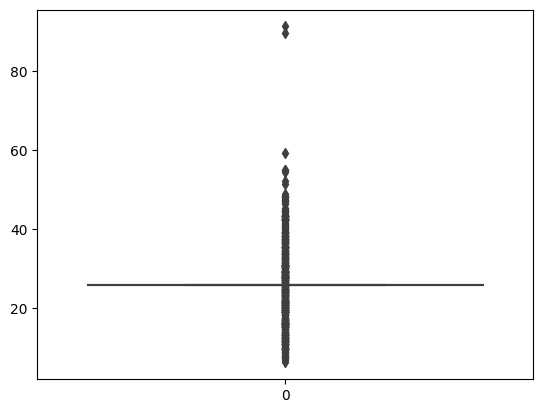

In [14]:
sb.boxplot(cleaned.LYMp)

Looks like nothing to remove here

#### NEUTp

This appears to be a neutrophil percentage of all white blood cells. So numbers above 100 or below 0 are definitely errors. 

<Axes: >

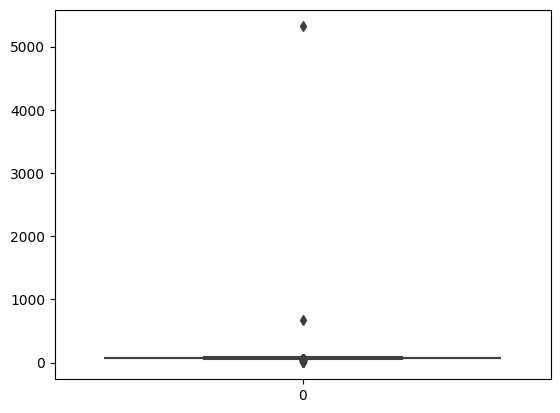

In [15]:
sb.boxplot(cleaned.NEUTp)

In [16]:
cleaned = cleaned[cleaned.NEUTp < 100]
cleaned = cleaned[cleaned.NEUTp > 0]

<Axes: >

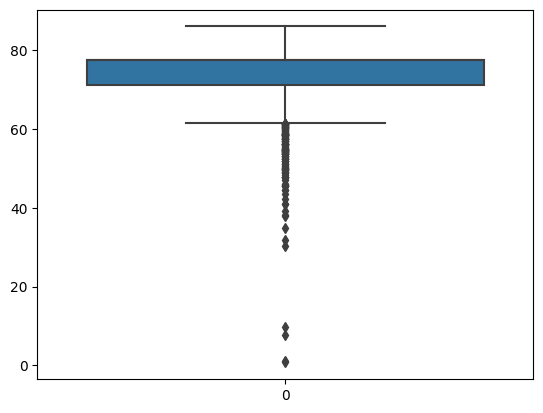

In [17]:
sb.boxplot(cleaned.NEUTp)

Much Better!

#### LYMn

This appears to be a lymphocyte count metric. 

For more information on the inptepretation and normal range here is a source: 

https://www.verywellhealth.com/what-are-lymphocytes-4140826

We can definitely say we have some outliers here.

<Axes: >

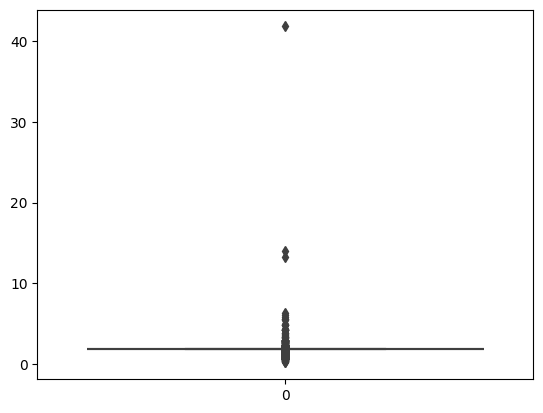

In [18]:
sb.boxplot(cleaned.LYMn)

Looks like we can set our cutoff at 30

In [19]:
cleaned = cleaned[cleaned.LYMn < 30]

<Axes: >

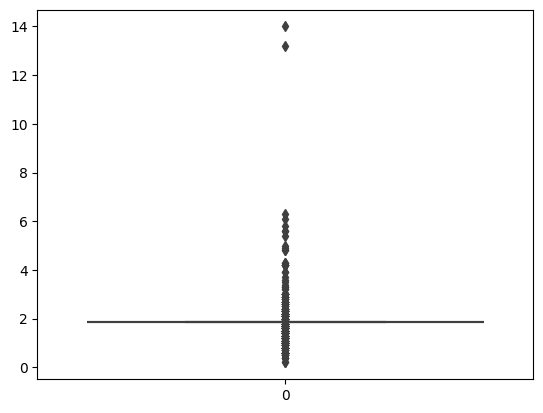

In [20]:
sb.boxplot(cleaned.LYMn)

#### NEUTn

This appears to be a neutrophil count metric. 

For more information here is a source: 

https://www.verywellhealth.com/what-are-neutrophils-p2-2249134

We can definitely say we have some outliers here that are not of the same order of magnitude. 

<Axes: >

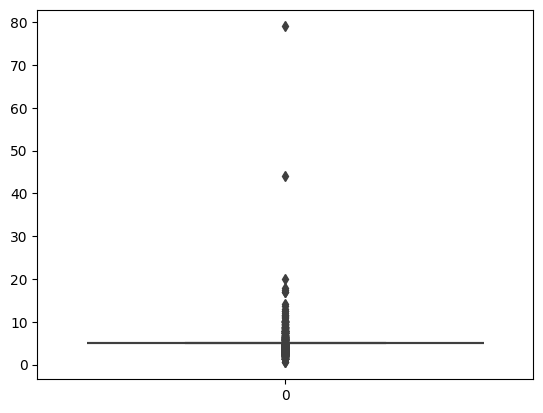

In [21]:
sb.boxplot(cleaned.NEUTn)

In [22]:
cleaned = cleaned[cleaned.NEUTn < 40]

<Axes: >

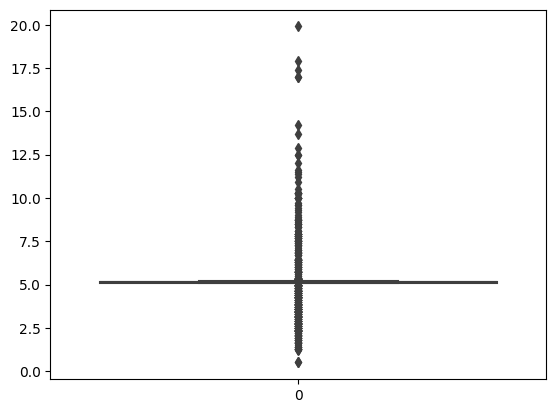

In [23]:
sb.boxplot(cleaned.NEUTn)

#### RBC

This is the red blood cell count. its normal range is between around 4 to 6. The values above 20 are very likely errors so I will remove them. 

Here is a source that talks more about this: 

https://www.verywellhealth.com/red-blood-cell-rbc-count-1942659

<Axes: >

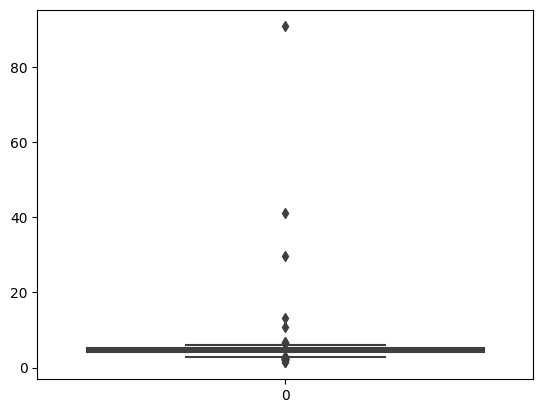

In [24]:
sb.boxplot(cleaned.RBC)

In [25]:
cleaned = cleaned[cleaned.RBC < 20]

<Axes: >

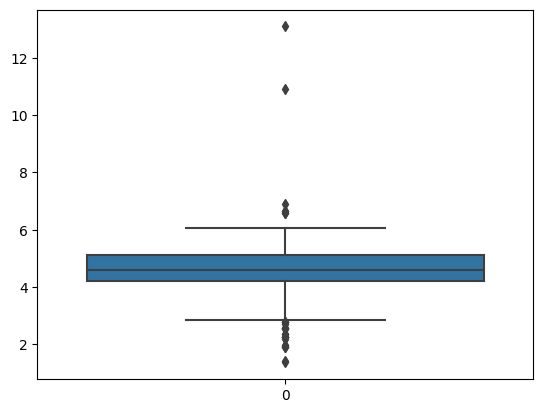

In [26]:
sb.boxplot(cleaned.RBC)

#### HGB

HGB is the amount of hemoglobin, it cannot be negative. so we can remove the negative cases

Here is a source as to it's normal ranges:

https://www.verywellhealth.com/hemoglobin-level-5211543

<Axes: >

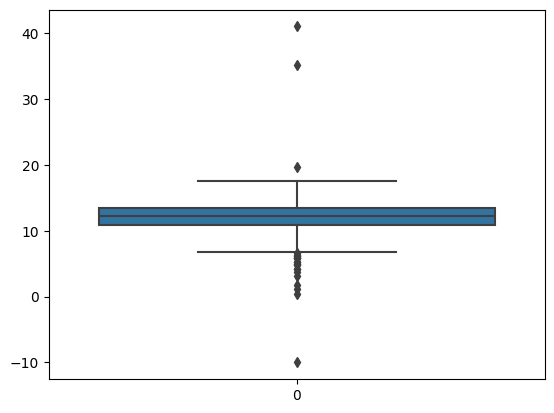

In [27]:
sb.boxplot(cleaned.HGB)

In [28]:
cleaned = cleaned[cleaned.HGB >= 0]

<Axes: >

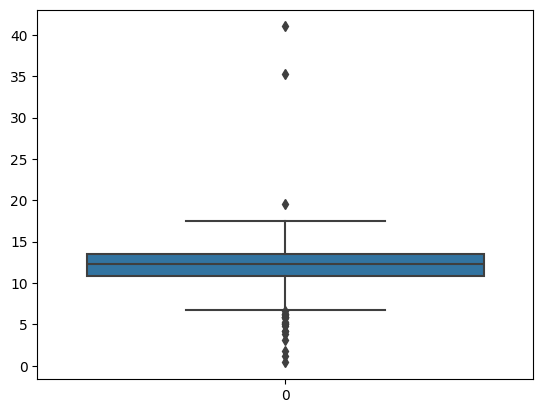

In [29]:
sb.boxplot(cleaned.HGB)

#### HCT

This is the result of the Hematocrit blood test. It tests how much of the blood is made of red blood cells. 

This value is in a percentage so values above 100% are definitely mistakes. 

For more info here is a resource: 

https://www.verywellhealth.com/hematocrit-level-test-1942505

<Axes: >

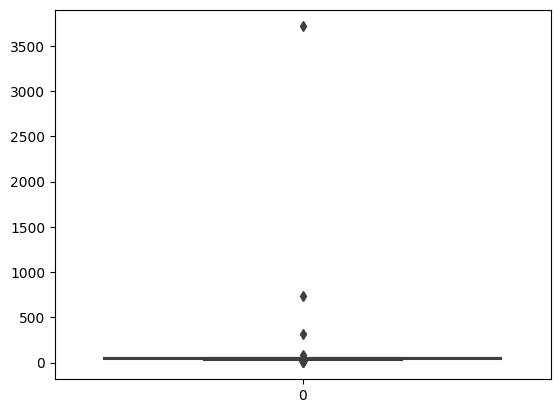

In [30]:
sb.boxplot(cleaned.HCT)

In [31]:
cleaned = cleaned[cleaned.HCT <100]

<Axes: >

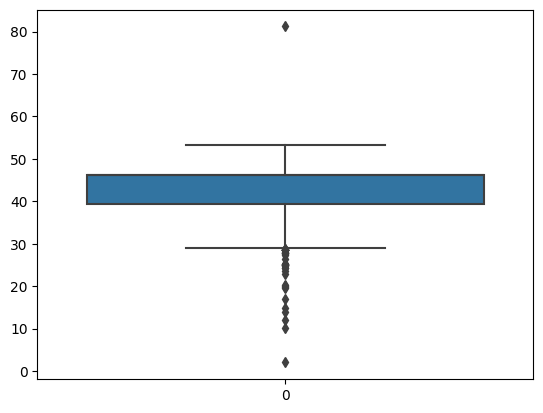

In [32]:
sb.boxplot(cleaned.HCT)

#### MCV

The MCV here is the average volume of the red blood cells, this number cannot be negative. So we have anomalies on both extremes. 

For its normal range here is a source: 

https://www.verywellhealth.com/mean-corpuscular-volume-overview-4583160

<Axes: >

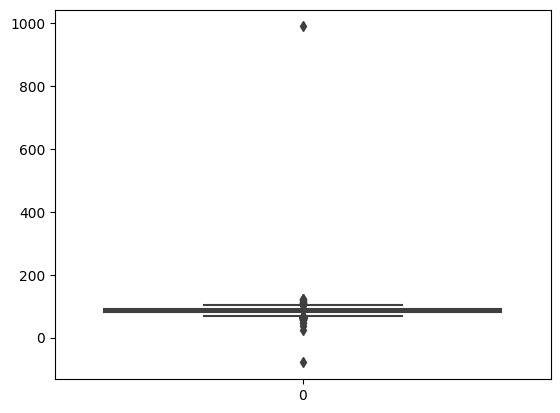

In [33]:
sb.boxplot(cleaned.MCV)

In [34]:
cleaned = cleaned[cleaned.MCV <250]
cleaned = cleaned[cleaned.MCV >= 0]

<Axes: >

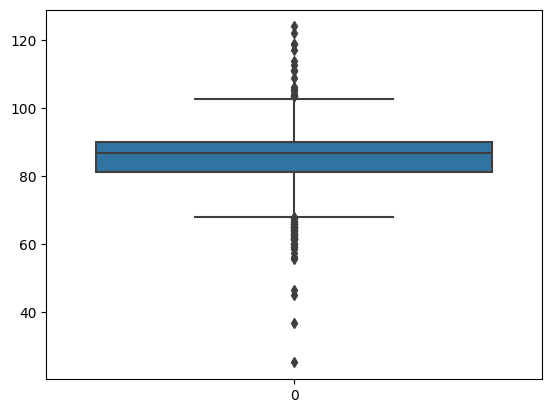

In [35]:
sb.boxplot(cleaned.MCV)

#### MCH

This is the Mean Corpuscular Hemoglobin. The average amount of Hemoglobin inside each red blood cell, for more info about this here is a read:

https://www.healthline.com/health/mch#testing

We can say that the 3000 value is definitely a mistake. 

<Axes: >

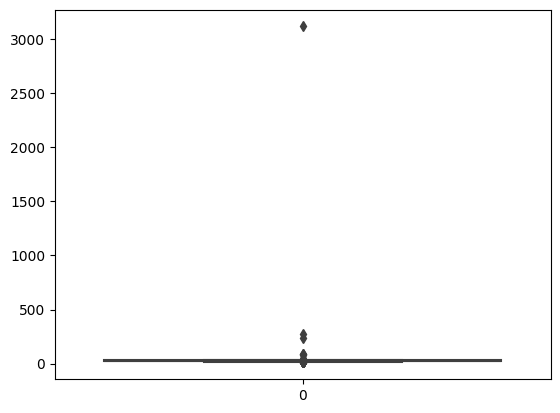

In [36]:
sb.boxplot(cleaned.MCH)

In [37]:
cleaned = cleaned[cleaned.MCH <200]

<Axes: >

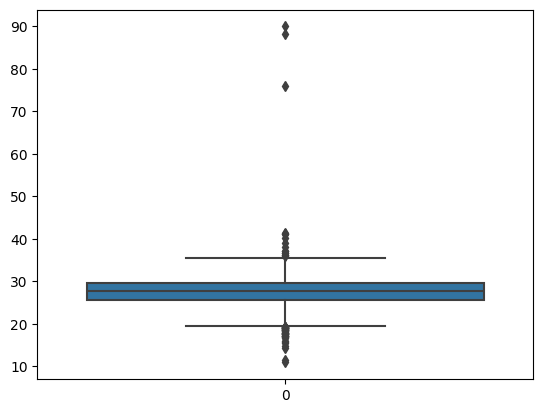

In [38]:
sb.boxplot(cleaned.MCH)

#### MCHC

Everything seems alright here

<Axes: >

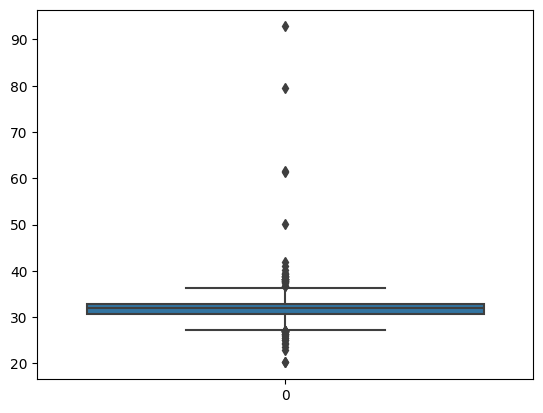

In [39]:
sb.boxplot(cleaned.MCHC)

#### PLT

Everything seems alright here

<Axes: >

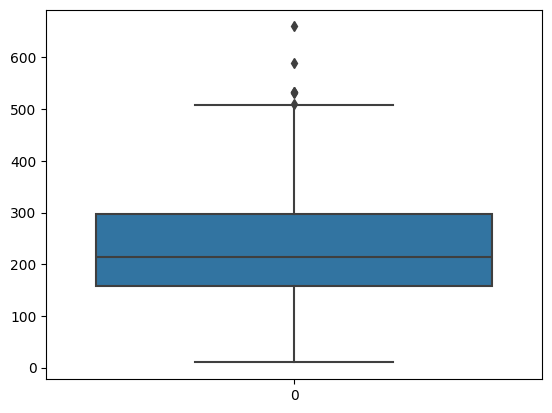

In [40]:
sb.boxplot(cleaned.PLT)

#### PDW

This is the platelet distribution width, its normal range is between 7 and 9. 

for more info here is a read:

https://pubmed.ncbi.nlm.nih.gov/19958208/

We do have anomalies in this case then.

<Axes: >

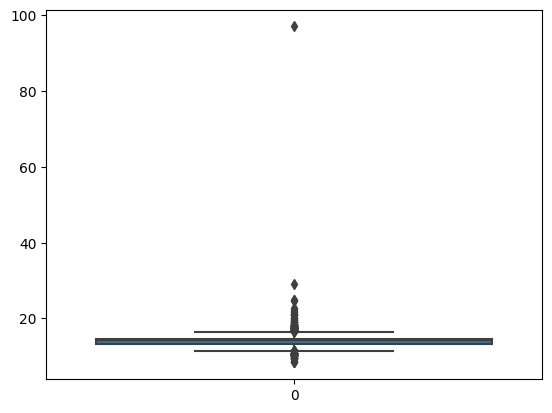

In [41]:
sb.boxplot(cleaned.PDW)

In [42]:
cleaned = cleaned[cleaned.PDW <40]

<Axes: >

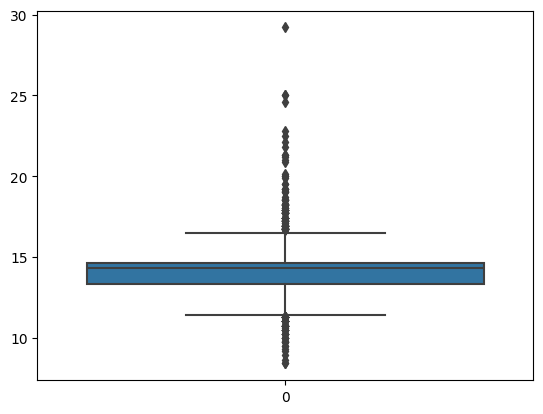

In [43]:
sb.boxplot(cleaned.PDW)

#### PCT

THis is the procalcitonin test result. 

For this test it is actually possible to have results above 10, as a result we can keep these numbers. 

For more info here is a source:

https://www.verywellhealth.com/procalcitonin-results-and-what-they-mean-3156825

<Axes: >

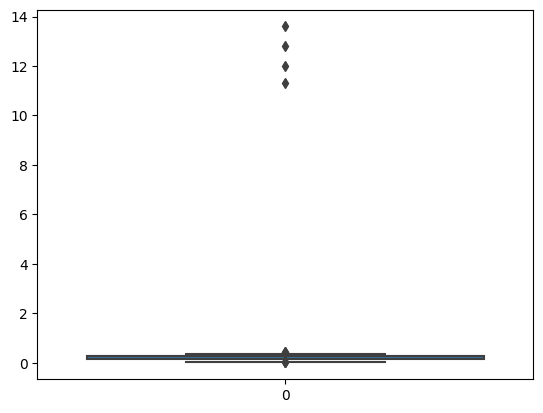

In [44]:
sb.boxplot(cleaned.PCT)

#### Final Plot:

<Axes: >

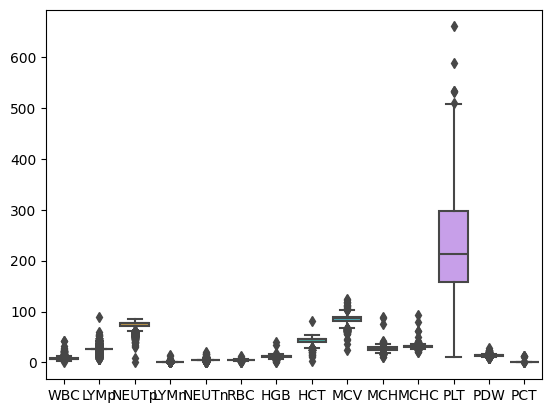

In [45]:
sb.boxplot(cleaned)

Okay we have removed the outliers, let's check how much we have removed.

In [46]:
cleaned.shape

(1263, 15)

We removed around 18 datapoints. Not a lot so should not affect our data accuracy. 

To make the subsequent steps run smoothly I am resetting the index

In [47]:
cleaned = cleaned.reset_index()

### Separate labels from the rest of data

Let's also separate the labels from the rest of the data and store it elsewhere. We can use it later. From what it looks like the labels do not need any more processing. 

In [48]:
labels = cleaned.Diagnosis

In [49]:
print(labels.isna().sum())

0


In [50]:
len(labels)

1263

In [51]:
cleaned_no_label = cleaned.drop(['Diagnosis'], axis = 1) 

In [52]:
cleaned_no_label.head()

,index,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT
0,0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17
1,1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16
2,2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14
3,3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12
4,5,6.6,27.3,65.4,1.8,4.3,3.96,8.8,29.7,75.2,22.2,79.6,207.0,11.5,0.18


In [53]:
cleaned_no_label.isna().sum()

index    0
WBC      0
LYMp     0
NEUTp    0
LYMn     0
NEUTn    0
RBC      0
HGB      0
HCT      0
MCV      0
MCH      0
MCHC     0
PLT      0
PDW      0
PCT      0
dtype: int64

### Scaling our features

The values above here we can see that our features are not to the same scale. We do not want these scales to mess with our distance measures for some of the later models. As a result we will probably need to scale our data for better model performance. 

We can see the impact of standardizing our data before feeding into our model. Here I will create a version of our data that has scaled features. 

In [54]:
from sklearn.preprocessing import StandardScaler

In [55]:
cleaned_scaled = StandardScaler().fit_transform(cleaned_no_label)

In [56]:
cleaned_scaled

array([[-1.74203480e+00,  6.39057610e-01,  2.60227376e+00, ...,
        -4.52750780e-01, -9.19893338e-01, -1.32878962e-01],
       [-1.73933260e+00,  6.39057610e-01,  2.48272340e+00, ...,
        -5.49770451e-01, -9.19893338e-01, -1.47375640e-01],
       [-1.73663040e+00, -1.87598961e-01,  7.34299394e-01, ...,
        -8.94729279e-01,  3.08952660e-02, -1.76368996e-01],
       ...,
       [ 1.71137565e+00,  4.02870018e-01,  8.77814844e-03, ...,
         1.05644409e+00,  3.75040761e-02, -2.00295195e-03],
       [ 1.71407785e+00, -4.00167793e-01,  8.77814844e-03, ...,
        -6.14450231e-01,  3.75040761e-02, -2.00295195e-03],
       [ 1.71678004e+00,  2.84776223e-01,  8.77814844e-03, ...,
         5.17445924e-01,  3.75040761e-02, -2.00295195e-03]])

In [57]:
cleaned_no_label.columns

Index(['index', 'WBC', 'LYMp', 'NEUTp', 'LYMn', 'NEUTn', 'RBC', 'HGB', 'HCT',
       'MCV', 'MCH', 'MCHC', 'PLT', 'PDW', 'PCT'],
      dtype='object')

In [58]:
cleaned_scaled = pd.DataFrame(cleaned_scaled, columns=[cleaned_no_label.columns])

In [59]:
cleaned_scaled.head()

,index,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT
0,-1.742035,0.639058,2.602274,-2.625572,3.393805,-0.027761,-2.326934,-2.040423,-3.004055,0.273645,-0.238950,-0.523269,-0.452751,-0.919893,-0.132879
1,-1.739333,0.639058,2.482723,-2.375046,3.255528,0.156311,-2.237531,-2.040423,-2.873390,0.331863,-0.370347,-3.596533,-0.549770,-0.919893,-0.147376
2,-1.736630,-0.187599,0.734299,-1.418488,0.489987,-0.395904,-0.794319,-1.317476,-1.975071,-0.972224,-1.049233,-0.709527,-0.894729,0.030895,-0.176369
3,-1.733928,-0.541880,0.659580,-1.099636,-0.063121,-0.764046,-0.475024,-3.528842,-1.599410,-0.867432,-0.917836,-0.616398,-0.948629,-1.553752,-0.205362
4,-1.728524,-0.364740,0.226210,-0.883272,-0.063121,-0.457261,-0.807090,-1.402529,-2.105736,-1.181810,-1.136831,14.843052,-0.258711,-1.448109,-0.118382


In [60]:
cleaned_scaled.isna().sum()

index    0
WBC      0
LYMp     0
NEUTp    0
LYMn     0
NEUTn    0
RBC      0
HGB      0
HCT      0
MCV      0
MCH      0
MCHC     0
PLT      0
PDW      0
PCT      0
dtype: int64

### Summary

Our data does not have any missing values. However there were some outliers/errors that needed to be removed. 

From the data understanding part we can tell that all of our columns are of the right data types. 

To make our data more suitable for analysis I have scaled the features so that our data is more suitable for dimentionality reduction as well as other models that rely on distance measures for their use. 

## EDA

### Bar plot for checking label balance

This part is to determine label frequencies and thus determine what evaluation metrics are best for model evaluation

For this part  iwill be using a trick suggested by this source:

https://blog.finxter.com/5-best-ways-to-create-a-frequency-plot-in-python-pandas-dataframe-using-matplotlib/

In [61]:
DiagnosisCounts = cleaned['Diagnosis'].value_counts()

In [62]:
DiagnosisCounts.head()

Diagnosis
Healthy                           335
Normocytic hypochromic anemia     274
Normocytic normochromic anemia    267
Iron deficiency anemia            184
Thrombocytopenia                   71
Name: count, dtype: int64

Text(0.5, 1.0, 'Diagnosis counts')

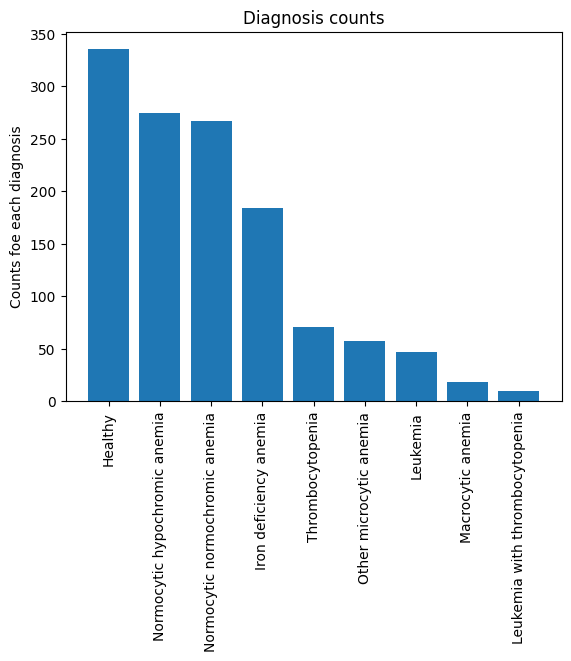

In [309]:
fig, ax = plt.subplots()
ax.bar(DiagnosisCounts.index, DiagnosisCounts.values)
plt.xticks(rotation=90)
ax.set_ylabel('Counts foe each diagnosis')
ax.set_title('Diagnosis counts')

Our labels are imbalanced. Basically this tells me that metrics like AUC and F1 are probably better. 

### Correlation matrices

For the following steps we will see if we have correlated features in our data

Granted, we actually no longer need to remove features like before because we can always use dimentionality reduction. Since interpretability is not important. 

For this part we can compare the scaled and not scaled data:

#### Scaled:

<Axes: xlabel='None', ylabel='None'>

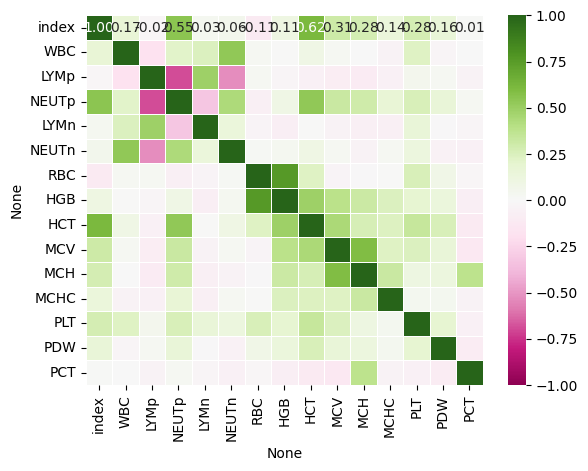

In [64]:
sb.heatmap(cleaned_scaled.corr(), annot=True, linewidth=.5, cmap="PiYG", fmt=".2f", vmin = -1, vmax = 1)

#### Not Scaled:

<Axes: >

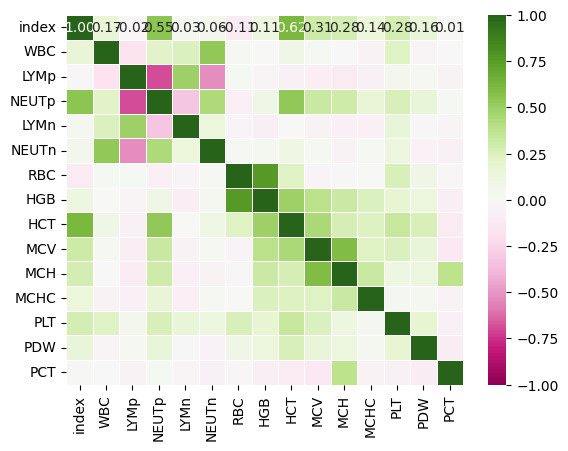

In [65]:
sb.heatmap(cleaned_no_label.corr(), annot=True, linewidth=.5, cmap="PiYG", fmt=".2f", vmin = -1, vmax = 1)

#### Conclusion:

feature scaling does not affect the correlation matrix

### Histograms

#### Scaled

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

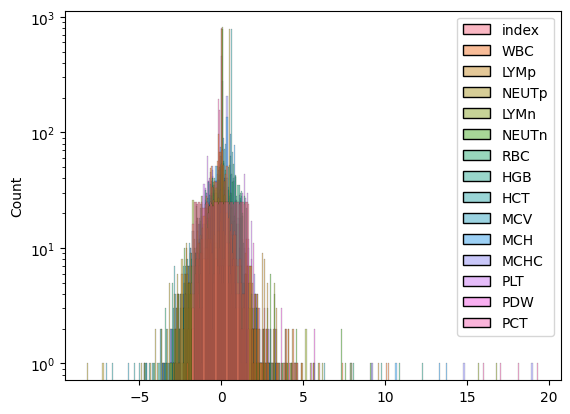

In [66]:
sb.histplot(cleaned_scaled, log_scale = (None, 10))

#### Not Scaled

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

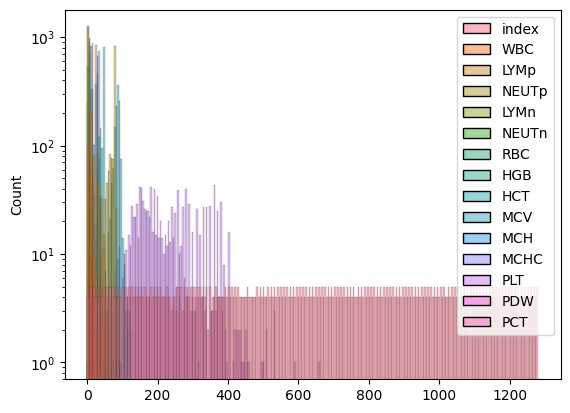

In [67]:
sb.histplot(cleaned_no_label, log_scale = (None, 10))

### Statistical tests (ANOVA)

For the statistical tests in this part we can conduct some ANOVA tests. What we will do is we will flip the relationship between the dependent and independent variables. For those that don't know, ANOVA essentially runs linear regression under the hood. For these tests we are actually more interested in the F-test result. 

What we are testing is that between the different diagnosis groups, is the blood test result significantly different from each other?

These tests do not say if the parwise comparisons are significant though. To do that w will need to do adjusted pairwise tests. 

I will use the scaled data to run these tests. 

In [68]:
cleaned.head()

,index,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,5,6.6,27.3,65.4,1.8,4.3,3.96,8.8,29.7,75.2,22.2,79.6,207.0,11.5,0.18,Other microcytic anemia


In [69]:
from pingouin import anova

In [70]:
anova(cleaned, dv = "WBC", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,32.109385,3.764397e-46,0.170017


In [71]:
anova(cleaned, dv = "LYMp", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,5.491031,7.782003e-07,0.033845


In [72]:
anova(cleaned, dv = "NEUTp", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,29.781583,7.442919e-43,0.15966


In [73]:
anova(cleaned, dv = "LYMn", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,2.805011,0.004398,0.01758


In [74]:
anova(cleaned, dv = "NEUTn", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,17.514137,6.320376e-25,0.100503


In [75]:
anova(cleaned, dv = "RBC", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,103.272623,3.990494e-132,0.397168


In [76]:
anova(cleaned, dv = "HGB", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,173.402733,8.741631e-197,0.52522


In [77]:
anova(cleaned, dv = "HCT", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,93.94456,2.976605e-122,0.374737


In [78]:
anova(cleaned, dv = "MCV", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,244.379237,1.286287e-249,0.609228


In [79]:
anova(cleaned, dv = "MCH", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,106.486607,1.904217e-135,0.404528


In [80]:
anova(cleaned, dv = "MCHC", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,35.901769,1.907121e-51,0.186356


In [81]:
anova(cleaned, dv = "PLT", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,62.012127,1.633694e-85,0.283468


In [82]:
anova(cleaned, dv = "PDW", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,8.286332,5.403709e-11,0.050209


In [83]:
anova(cleaned, dv = "PCT", between = "Diagnosis")

,Source,ddof1,ddof2,F,p-unc,np2
0,Diagnosis,8,1254,3.431016,0.000649,0.02142


### Train test split (for both scaled and unscaled)

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
scaled_train, scaled_test, scaled_label_train, scaled_label_test = train_test_split(cleaned_scaled, labels, train_size = 0.8, test_size=0.2, random_state=6)

In [86]:
unscaled_train, unscaled_test, unscaled_label_train, unscaled_label_test = train_test_split(cleaned_no_label, labels, train_size = 0.8, test_size=0.2, random_state=6)

### Summary

Our labels are imbalanced. This may create a problem with training some models. A model evaluation metric more robust to imbalanced data like ROC, AUC, and F1 are probably best. 

We definitely see the effects on the distributions as a result of feature scaling. 

The ANOVA tests shows that our different diagnosis groups are significantly different for each of the features. This is quite good news. 

It looks like other than the correlated features our data seems good to use. 

## Model Fitting part 1: Understanding the underlying structures of our data using unsupervised learning (and possibly reducing the dimensions of our data)

### Cumulative Explained Variance Ratio plot using PCA (hyperparemeter tuning)

This will inform us of how many dimentions we should keep in case we want to do dimentionality reduction in the future. This part will be done with the scaled data

In [87]:
from sklearn.decomposition import PCA

In [88]:
PCA_data = PCA().fit(cleaned_scaled)

explained_variance_ratio = PCA_data.explained_variance_ratio_

cum_sum_explained_variance_ratio = np.cumsum(explained_variance_ratio)

cum_sum_explained_variance_ratio = pd.DataFrame(cum_sum_explained_variance_ratio, columns=["Cumulative_Explained_Variance"])

cum_sum_explained_variance_ratio = cum_sum_explained_variance_ratio.assign(Number_of_PCs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

In [89]:
print(cum_sum_explained_variance_ratio)

    Cumulative_Explained_Variance  Number_of_PCs
0                        0.234670              1
1                        0.377227              2
2                        0.494587              3
3                        0.600027              4
4                        0.684895              5
5                        0.754105              6
6                        0.811229              7
7                        0.862551              8
8                        0.908045              9
9                        0.941446             10
10                       0.960460             11
11                       0.975370             12
12                       0.987893             13
13                       0.995033             14
14                       1.000000             15


C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Cumulative Explained Variance by number of Principal Components')]

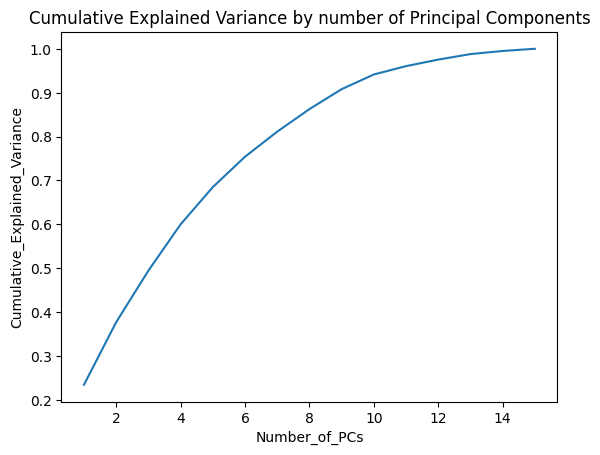

In [90]:
sb.lineplot(y = cum_sum_explained_variance_ratio.Cumulative_Explained_Variance, x = cum_sum_explained_variance_ratio.Number_of_PCs).set(title='Cumulative Explained Variance by number of Principal Components')

Based on what we got here we can use 8 principal compoents to explain 90% of the variability in our data. 

### Dimentionality reduction using PCA

We have established that 8 principal components are needed to explain 90% of the variability in the data. Let's create train and test sets from this.

In [91]:
eight_component_data = PCA(n_components = 8).fit_transform(cleaned_scaled)

eight_component_data = pd.DataFrame(eight_component_data, columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])

eight_component_train, eight_component_test, eight_component_label_train, eight_component_label_test = train_test_split(eight_component_data, labels, train_size = 0.8, test_size=0.2, random_state=6)

### Visualizing the groups on a 2d plane using PCA

This part I will use dimentionality reduction to create a 2d plot of our data and see if we can visualize the clusters, I can't use explained variance because of the 2d constraint. I will use the scaled data to do this

<Axes: xlabel='PC1', ylabel='PC2'>

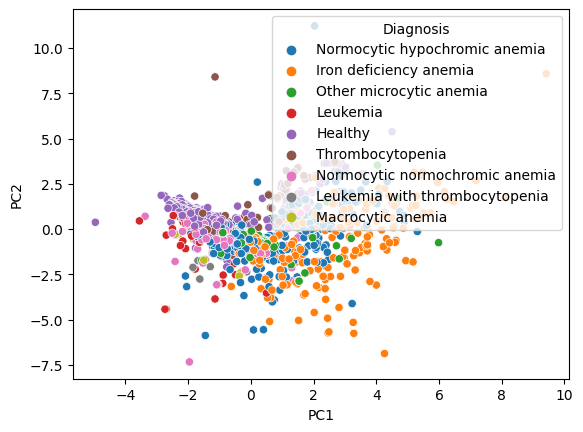

In [92]:
reduced_data_2Comp = PCA(n_components=2).fit_transform(cleaned_scaled)

reduced_data_2Comp = pd.DataFrame(reduced_data_2Comp, columns=["PC1", "PC2"])

reduced_data_2Comp = reduced_data_2Comp.assign(Diagnosis=labels)

sb.scatterplot(data = reduced_data_2Comp, x = "PC1", y = "PC2", hue = "Diagnosis", legend = 'full')

### Visualizing the groups on a 2d plane using t-SNE (model not covered in class)

That was dissapointing, perhaps t-SNE will work better. Let's give it a try, our original data is already not all that high dimentional. The runtime should be fine. 

<Axes: xlabel='a', ylabel='b'>

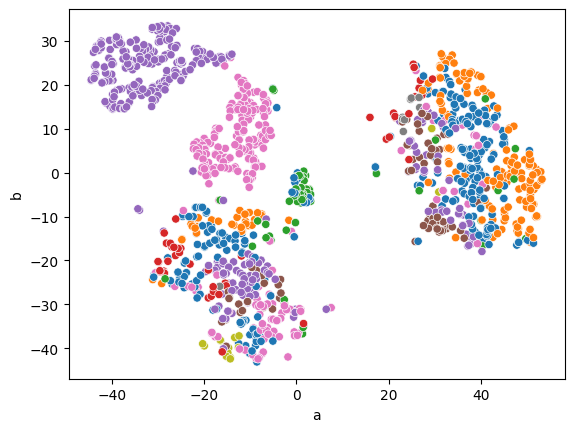

In [93]:
from sklearn.manifold import TSNE

reduced_data_2Comp_TSNE = TSNE(n_components=2, perplexity = 30).fit_transform(cleaned_scaled)

reduced_data_2Comp_TSNE = pd.DataFrame(reduced_data_2Comp_TSNE, columns=["a", "b"])

reduced_data_2Comp_TSNE = reduced_data_2Comp_TSNE.assign(Diagnosis=labels)

sb.scatterplot(data = reduced_data_2Comp_TSNE, x = "a", y = "b", hue = "Diagnosis", legend = False)

For this plot I removed the ledgend for easier viewing. The color scheme is just the same as before. 

The saparation on this is much easier to see than on the PCA. Excellent. 

### Hierarchical Clustering (with tuning distance metric and linkage type)

#### Visualizing the clusters using Dendrograms of our data

For the dendrogram plot I am taking a trick from this source

https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

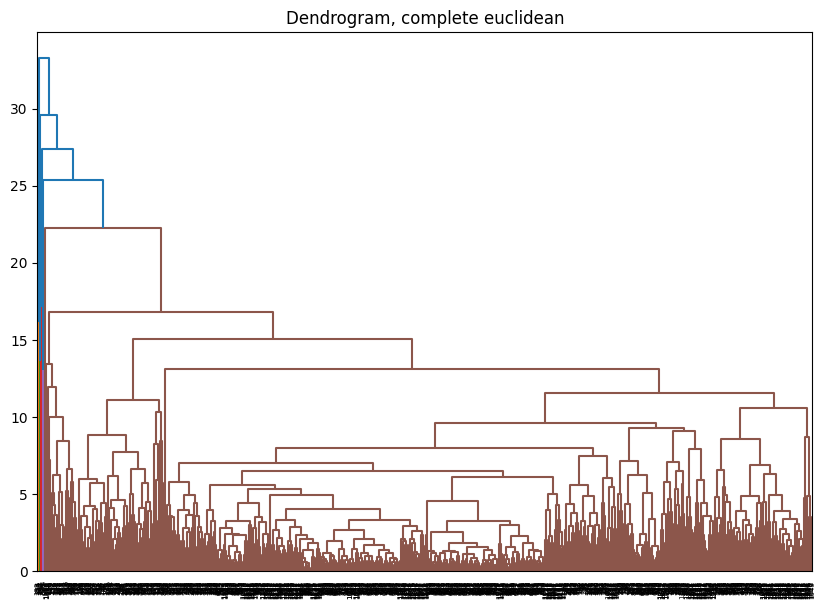

In [94]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Dendrogram, complete euclidean")

clusters = shc.linkage(cleaned_scaled, method='complete', metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

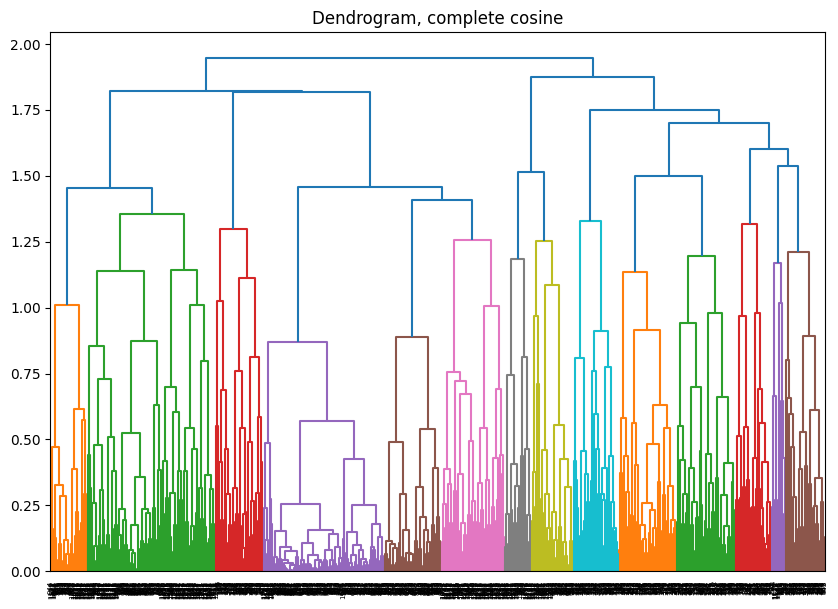

In [95]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, complete cosine")

clusters = shc.linkage(cleaned_scaled, method='complete', metric="cosine")
shc.dendrogram(Z=clusters)
plt.show()

This dendrogram seems to show the most even separations. And it seems to be saying that there are 14 groups in our data.

Although from the labels we have, this even separation actually might not be desirable because our labels are actually very imbalanced. 

I wonder what underlying structure this is picking up here. Perhaps underlying demographic information from the patients unrelated to the conditions? 
Afterall these bloodwork results can also be used to infer the likely age and gender of the individual. 

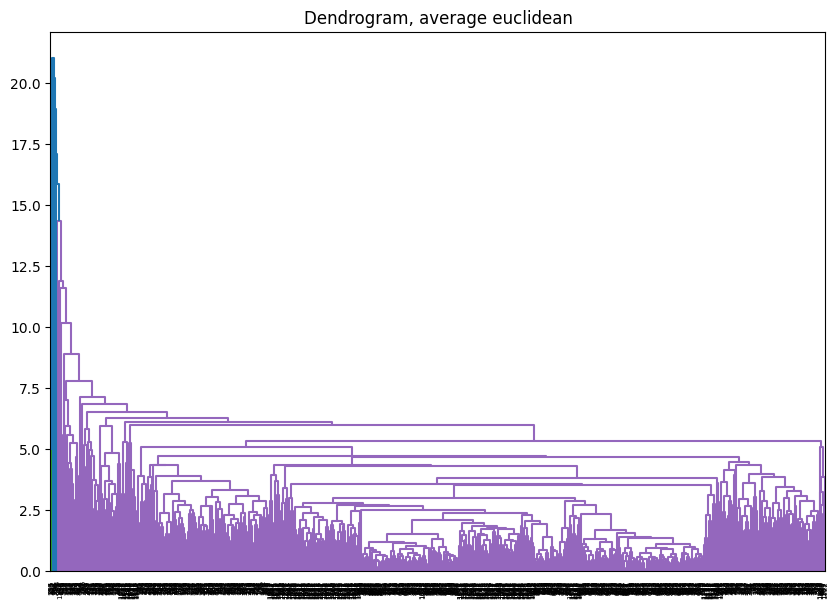

In [96]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, average euclidean")

clusters = shc.linkage(cleaned_scaled, method='average', metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

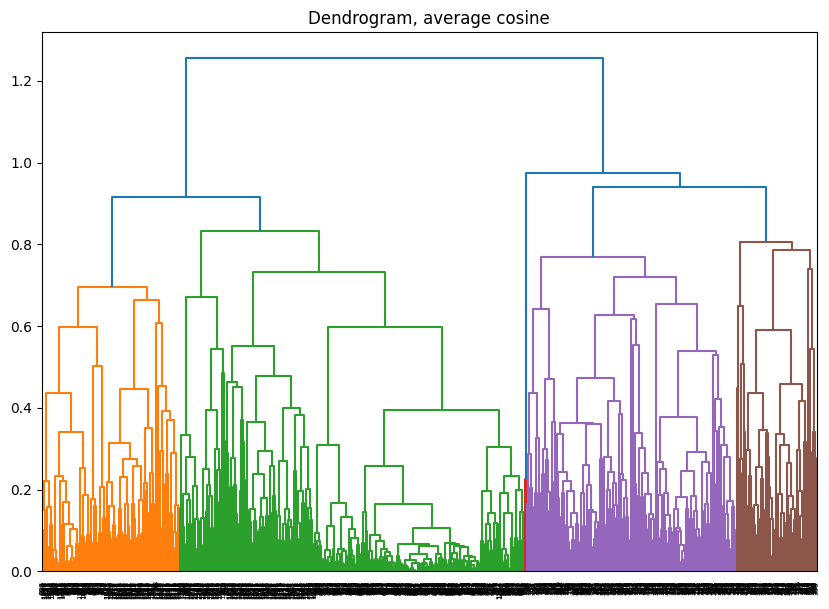

In [97]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, average cosine")

clusters = shc.linkage(cleaned_scaled, method='average', metric="cosine")
shc.dendrogram(Z=clusters)
plt.show()

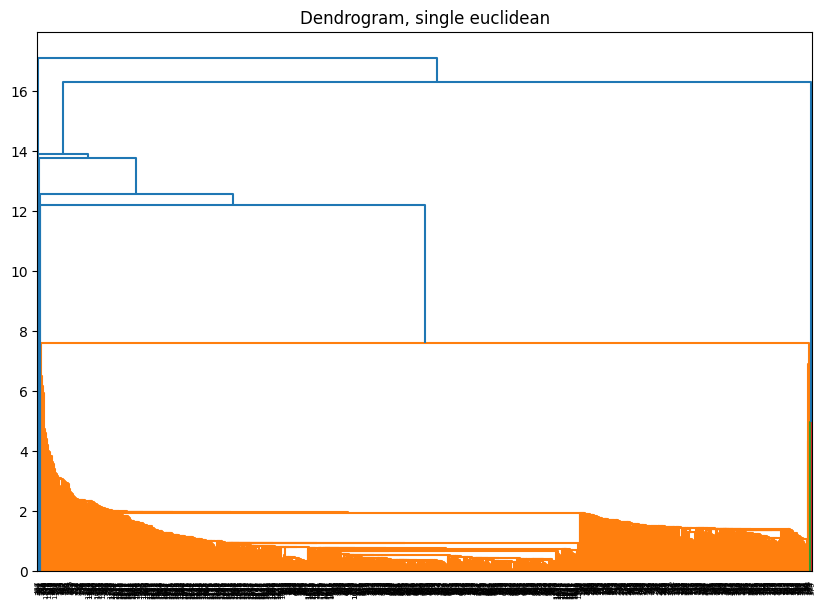

In [310]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, single euclidean")

clusters = shc.linkage(cleaned_scaled, method='single', metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Well that is not informative

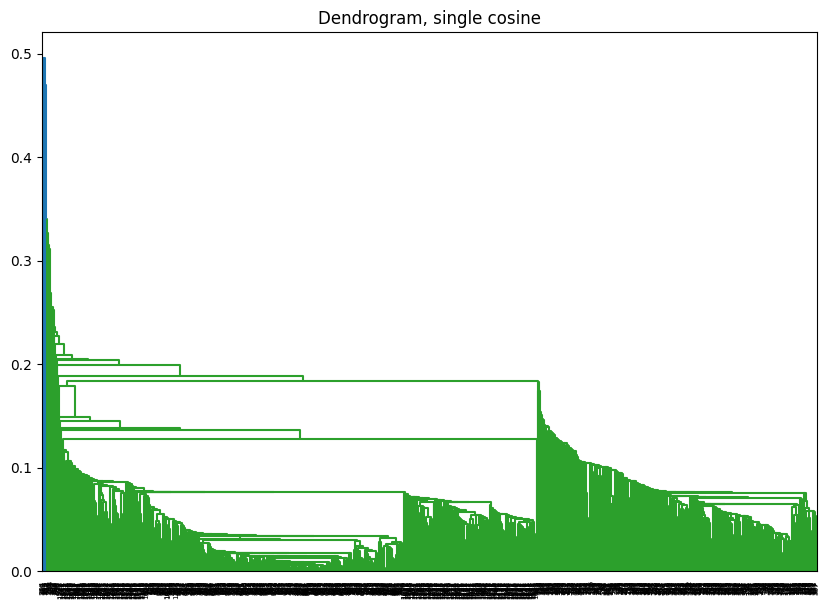

In [312]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, single cosine")

clusters = shc.linkage(cleaned_scaled, method='single', metric="cosine")
shc.dendrogram(Z=clusters)
plt.show()

Looks like our dataset just does not like the single method

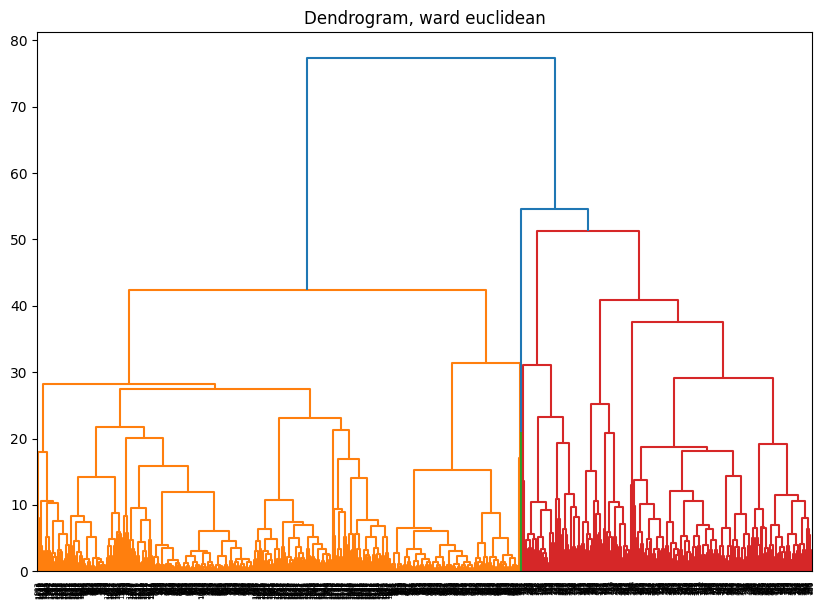

In [311]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram, ward euclidean")

clusters = shc.linkage(cleaned_scaled, method='ward', metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

### K-means Clustering (with tuning K)

#### Using inertia plot to determine best number of clusters

In [101]:
from sklearn.cluster import KMeans

In [102]:
K = 15
inertia = []
for k in range(1,K):
    k_means_model = KMeans(n_clusters = k, n_init = 'auto').fit(cleaned_scaled)
    inertia.append(k_means_model.inertia_)

C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

In [103]:
inertia_kmeans = pd.DataFrame(inertia, columns=["inertia"])

inertia_kmeans = inertia_kmeans.assign(number_of_clusters=[x for x in range(1,K)])

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'inertia by number of clusters')]

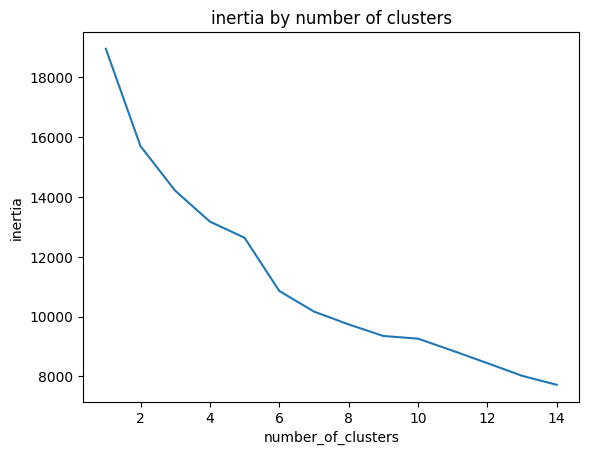

In [104]:
sb.lineplot(y = inertia_kmeans.inertia, x = inertia_kmeans.number_of_clusters).set(title='inertia by number of clusters')

According to this our optimal number of clusters is around 3 to 8 

But I have to say, this result is disappointing. The plot did not really show a clear elbow. 

### NMF

#### Plotting reconstruction error to see the optimal number of factors (hyperparameter tuning)

Based on the boxplots we had before, our data would probably be best served by a frobenius loss function. But let's try others too just so see how well they work. 

For this part I am using an idea suggested from this forum:

https://www.researchgate.net/post/Difference_between_PCA_and_NMF

NMF does not like the scaled data, so I will use the unscaled data to do this step

In [105]:
from sklearn.decomposition import NMF

In [106]:
Max_factor_Num = 16

Too bad I can't use the Sklearn library to tune the regularization parameter here. I am including regularization because otherwise convergence takes way too long. 

The choice of loss function is not random. Our data is not sparse and values are not close to 0 as seen during EDA. So frobenius loss is best based on our EDA.  

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Reconstruction Error by Number of Components, frobenius loss with cd solver')]

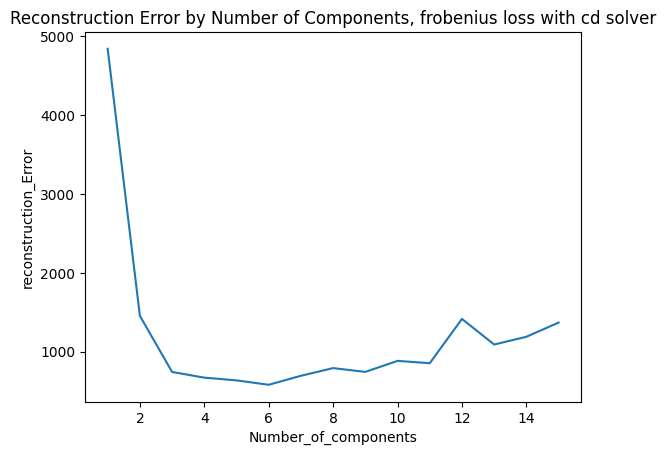

In [321]:
reconstruction_Error = []
for factorNumber in range(1,Max_factor_Num):
    
    NMFModel = NMF(n_components = factorNumber, solver = 'cd', beta_loss = 'frobenius', alpha_W = 0.01, alpha_H = 'same', verbose = 0, max_iter=200000).fit(cleaned_no_label)
    error = NMFModel.reconstruction_err_
    reconstruction_Error.append(error)

reconstruction_Error_df = pd.DataFrame(reconstruction_Error, columns = ['reconstruction_Error'])

reconstruction_Error_df = reconstruction_Error_df.assign(Number_of_components=[x for x in range(1,Max_factor_Num)])

sb.lineplot(y = reconstruction_Error_df.reconstruction_Error, x = reconstruction_Error_df.Number_of_components).set(title='Reconstruction Error by Number of Components, frobenius loss with cd solver')

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Reconstruction Error by Number of Components, frobenius loss with mu solver')]

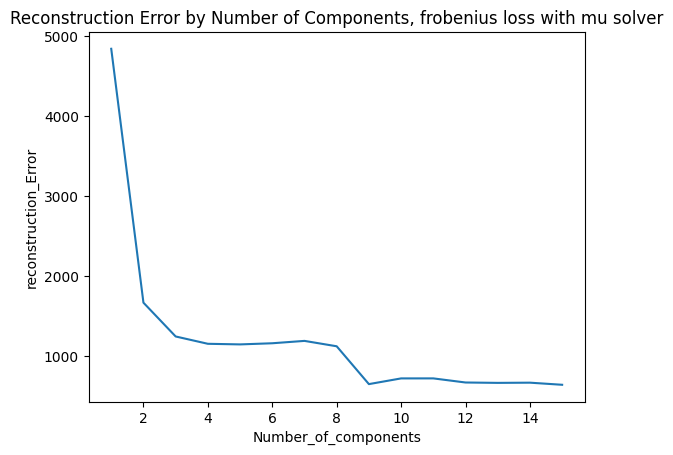

In [319]:
reconstruction_Error = []
for factorNumber in range(1,Max_factor_Num):
    
    NMFModel = NMF(n_components = factorNumber, solver = 'mu', beta_loss = 'frobenius', alpha_W = 0.01, alpha_H = 'same', verbose = 0, max_iter=200000).fit(cleaned_no_label)
    error = NMFModel.reconstruction_err_
    reconstruction_Error.append(error)

reconstruction_Error_df = pd.DataFrame(reconstruction_Error, columns = ['reconstruction_Error'])

reconstruction_Error_df = reconstruction_Error_df.assign(Number_of_components=[x for x in range(1,Max_factor_Num)])

sb.lineplot(y = reconstruction_Error_df.reconstruction_Error, x = reconstruction_Error_df.Number_of_components).set(title='Reconstruction Error by Number of Components, frobenius loss with mu solver')

C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Johns\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Reconstruction Error by Number of Components, KL loss with mu solver')]

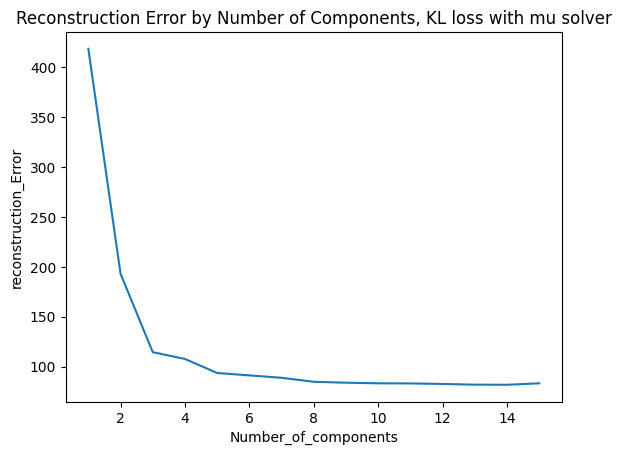

In [318]:
reconstruction_Error = []
for factorNumber in range(1,Max_factor_Num):
    
    NMFModel = NMF(n_components = factorNumber, solver = 'mu', beta_loss = 'kullback-leibler', alpha_W = 0.01, alpha_H = 'same', verbose = 0, max_iter=200000).fit(cleaned_no_label)
    error = NMFModel.reconstruction_err_
    reconstruction_Error.append(error)

reconstruction_Error_df = pd.DataFrame(reconstruction_Error, columns = ['reconstruction_Error'])

reconstruction_Error_df = reconstruction_Error_df.assign(Number_of_components=[x for x in range(1,Max_factor_Num)])

sb.lineplot(y = reconstruction_Error_df.reconstruction_Error, x = reconstruction_Error_df.Number_of_components).set(title='Reconstruction Error by Number of Components, KL loss with mu solver')

### Dimensionality reduction using NMF

For this part, I will use the results of the reconstruction error plot to try to create lower dimensional representation of our data. 

The plots seems to be all saying that 3 components seems to be best. I wonder why though. Let's create the datasets and see if they imporve the performance of a supervised learning model that is sensitive to high dimensions. 

In [110]:
NMF_cd_frobenius = NMF(n_components = 3, solver = 'cd', beta_loss = 'frobenius', alpha_W = 0.01, alpha_H = 'same', verbose = 0, max_iter=200000).fit_transform(cleaned_no_label)

NMF_cd_frobenius = pd.DataFrame(NMF_cd_frobenius, columns = ["c1", "c2", "c3"])

NMF_cd_frobenius_train, NMF_cd_frobenius_test, NMF_cd_frobenius_label_train, NMF_cd_frobenius_label_test = train_test_split(NMF_cd_frobenius, labels, train_size = 0.8, test_size=0.2, random_state=6)

In [111]:
NMF_mu_frobenius = NMF(n_components = 3, solver = 'mu', beta_loss = 'frobenius', alpha_W = 0, alpha_H = 'same', verbose = 0, max_iter=200000).fit_transform(cleaned_no_label)

NMF_mu_frobenius = pd.DataFrame(NMF_mu_frobenius, columns = ["c1", "c2", "c3"])

NMF_mu_frobenius_train, NMF_mu_frobenius_test, NMF_mu_frobenius_label_train, NMF_mu_frobenius_label_test = train_test_split(NMF_mu_frobenius, labels, train_size = 0.8, test_size=0.2, random_state=6)

In [112]:
NMF_mu_KL = NMF(n_components = 3, solver = 'mu', beta_loss = 'kullback-leibler', alpha_W = 0, alpha_H = 'same', verbose = 0, max_iter=200000).fit_transform(cleaned_no_label)

NMF_mu_KL = pd.DataFrame(NMF_mu_KL, columns = ["c1", "c2", "c3"])

NMF_mu_KL_train, NMF_mu_KL_test, NMF_mu_KL_label_train, NMF_mu_KL_label_test = train_test_split(NMF_mu_KL, labels, train_size = 0.8, test_size=0.2, random_state=6)

## Model Fitting part 2: Predicting our diagnosis both with supervised and unsupervised techniques

### Support Vector Machine model (supervised learning)

In [113]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, confusion_matrix, roc_curve, roc_auc_score, f1_score

In [114]:
cVal = list(range(-5,5))
gammaVal = list(range(-10,0))
gammaVal = [(2)**(x) for x in gammaVal]
cVal = [(2)**(x) for x in cVal]
SVCParamGrid = {'C': cVal, 'gamma': gammaVal}
#SVRParamGrid = {'C': cVal}
SVCGrid = GridSearchCV(estimator = SVC(max_iter = -1, kernel = 'rbf', probability = True), param_grid = SVCParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(scaled_train, scaled_label_train)
SVCGrid.best_params_

{'C': 16, 'gamma': 0.03125}

In [115]:
SVCGrid.best_score_

0.990036284544758

In [116]:
SVC_model = SVCGrid.best_estimator_

In [117]:
SVC_model_prediction = SVC_model.predict(scaled_test)

In [118]:
confusion_matrix(scaled_label_test, SVC_model_prediction)

array([[59,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1, 32,  0,  0,  0,  2,  0,  0,  0],
       [ 2,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 4,  3,  0,  0,  1, 49,  1,  4,  0],
       [ 0,  0,  0,  0,  0,  3, 49,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  7,  0],
       [ 2,  0,  0,  0,  0,  0,  2,  0, 21]], dtype=int64)

In [119]:
f1_score(scaled_label_test, SVC_model_prediction, average='micro')

0.8774703557312253

In [120]:
f1_score(scaled_label_test, SVC_model_prediction, average='macro')

0.7196985800699568

In [121]:
SVC_model_prediction_probalility = SVC_model.predict_proba(scaled_test)

In [122]:
roc_auc_score(scaled_label_test, SVC_model_prediction_probalility, average='micro', multi_class='ovr')

0.9936219906575637

In [123]:
roc_auc_score(scaled_label_test, SVC_model_prediction_probalility, average='macro', multi_class='ovr')

0.9922994751314843

### Gradient Boosting model (supervised Learning)

In [124]:
from sklearn.ensemble import GradientBoostingClassifier

In [125]:
learningRate = list(range(1,20))
learningRate = [(x/100) for x in learningRate]
GBMParamGrid = {'learning_rate': learningRate, 'n_estimators': list(range(10,100, 10))}
GBMGrid = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = GBMParamGrid, scoring = 'roc_auc_ovr',cv = 5).fit(scaled_train, scaled_label_train)
GBMGrid.best_params_

{'learning_rate': 0.08, 'n_estimators': 80}

In [126]:
GBMGrid.best_score_

0.9996874773386398

In [127]:
GBM_model = GBMGrid.best_estimator_

In [128]:
GBM_model_prediction = GBM_model.predict(scaled_test)

In [129]:
confusion_matrix(scaled_label_test, GBM_model_prediction)

array([[60,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 35,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 62,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 52,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0, 24]], dtype=int64)

In [130]:
f1_score(scaled_label_test, GBM_model_prediction, average='micro')

0.9841897233201581

In [131]:
f1_score(scaled_label_test, GBM_model_prediction, average='macro')

0.8702916028976635

In [132]:
GBM_model_prediction_probalility = GBM_model.predict_proba(scaled_test)

In [133]:
roc_auc_score(scaled_label_test, GBM_model_prediction_probalility, average='micro', multi_class='ovr')

0.9965590776297084

In [134]:
roc_auc_score(scaled_label_test, GBM_model_prediction_probalility, average='macro', multi_class='ovr')

0.9907563352826512

### Complement Naive Bayes (Supervised learning)

This model does not like the scaled data, so I will use the unscaled data to test things. 

In [135]:
from sklearn.naive_bayes import ComplementNB

In [136]:
alpha = list(range(-10,10))
alpha = [(2)**(x) for x in learningRate]
NBParamGrid = {'alpha': alpha}

NBGrid = GridSearchCV(estimator = ComplementNB(force_alpha = True), param_grid = NBParamGrid, scoring = 'roc_auc_ovr',cv = 5).fit(unscaled_train, unscaled_label_train)
NBGrid.best_params_

{'alpha': 1.0069555500567189}

In [137]:
NBGrid.best_score_

0.5935610792795634

In [138]:
NB_model = NBGrid.best_estimator_

In [139]:
NB_model_prediction = NB_model.predict(unscaled_test)

In [140]:
confusion_matrix(unscaled_label_test, NB_model_prediction)

array([[39,  5,  0,  0,  0,  0, 16,  0,  0],
       [ 2, 20,  0,  0,  0,  6,  7,  0,  0],
       [ 1,  2,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  1,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 1, 29,  0,  0,  0,  2, 30,  0,  0],
       [10, 12,  0,  0,  0,  1, 29,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  6,  0,  0],
       [ 0, 12,  0,  0,  0,  5,  8,  0,  0]], dtype=int64)

In [141]:
f1_score(unscaled_label_test, NB_model_prediction, average='micro')

0.3557312252964427

In [142]:
f1_score(unscaled_label_test, NB_model_prediction, average='macro')

0.16116103728440917

In [143]:
NB_model_prediction_probalility = NB_model.predict_proba(unscaled_test)

In [144]:
roc_auc_score(unscaled_label_test, NB_model_prediction_probalility, average='micro', multi_class='ovr')

0.6336745613898047

In [145]:
roc_auc_score(unscaled_label_test, NB_model_prediction_probalility, average='macro', multi_class='ovr')

0.5026815208986457

### QDA (Supervised Learning)

In [146]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [293]:
reg_param = list(range(0,1000))
reg_param = [(x/100) for x in learningRate]
QDAParamGrid = {'reg_param': reg_param}

QDAGrid = GridSearchCV(estimator = QuadraticDiscriminantAnalysis(), param_grid = QDAParamGrid, scoring = 'roc_auc_ovr',cv = 5).fit(scaled_train, scaled_label_train)
QDAGrid.best_params_

C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Johns\anaconda3\Lib\site-

{'reg_param': 0.0019}

In [294]:
QDAGrid.best_score_

0.8854555755920114

In [295]:
QDA_model = QDAGrid.best_estimator_

In [296]:
QDA_model_prediction = QDA_model.predict(scaled_test)

In [297]:
confusion_matrix(scaled_label_test, QDA_model_prediction)

array([[52,  2,  2,  0,  1,  0,  3,  0,  0],
       [ 1, 34,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  2,  0,  0,  0,  0],
       [ 5, 24,  0,  0,  5,  7, 20,  0,  1],
       [ 2,  1,  0,  1,  2,  1, 42,  1,  2],
       [ 1,  1,  1,  0,  0,  0,  3,  3,  0],
       [ 1,  1,  2,  0,  1,  0,  3,  0, 17]], dtype=int64)

In [298]:
f1_score(scaled_label_test, QDA_model_prediction, average='micro')

0.6284584980237155

In [299]:
f1_score(scaled_label_test, QDA_model_prediction, average='macro')

0.47133087856973266

In [300]:
QDA_model_prediction_probalility = QDA_model.predict_proba(scaled_test)

In [301]:
roc_auc_score(scaled_label_test, QDA_model_prediction_probalility, average='micro', multi_class='ovr')

0.913191894889781

In [302]:
roc_auc_score(scaled_label_test, QDA_model_prediction_probalility, average='macro', multi_class='ovr')

0.8664013670909738

### KNN (Supervised Learning, model to test the unsupervised dimensionality reductions on)

For this I will use the results of the variaous dimensionality reduction techniques and see how well they compare. This is interesting because we know that KNN is sensitive to high dimensions and we can thus see what (if any) of the reduction techniques is best at addressing high dimensions. 

##### Let's first start with the unscaled original data

In [157]:
from sklearn.neighbors import KNeighborsClassifier

In [158]:
kVal = list(range(1,70))
kNNParamGrid = {'n_neighbors': kVal}
kNN_unscaled_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(unscaled_train, unscaled_label_train)
kNN_unscaled_Grid.best_params_

{'n_neighbors': 21}

In [159]:
kNN_unscaled_Grid.best_score_

0.8417037590077598

##### Let's now do the scaled data

In [206]:
kNN_scaled_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(scaled_train, scaled_label_train)
kNN_scaled_Grid.best_params_

{'n_neighbors': 24}

In [207]:
kNN_scaled_Grid.best_score_

0.9582000588336765

In [213]:
kNN_scaled_prediction = kNN_scaled_Grid.best_estimator_.predict_proba(scaled_test)

roc_auc_score(scaled_label_test, kNN_scaled_prediction, multi_class = 'ovr')

0.9512152806318187

So we can see that scaling the data does help with the performance of the kNN model. 

##### Let's now try the reduced data from PCA:

In [162]:
kNN_pca_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(eight_component_train, eight_component_label_train)
kNN_pca_Grid.best_params_

{'n_neighbors': 33}

In [163]:
kNN_pca_Grid.best_score_

0.9519176373041545

##### Let's try the result of NMF (with the various loss functions) and see how well that works:

In [164]:
kNN_NMF_cd_frobenius_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(NMF_cd_frobenius_train, NMF_cd_frobenius_label_train)
kNN_NMF_cd_frobenius_Grid.best_params_

{'n_neighbors': 23}

In [165]:
kNN_NMF_cd_frobenius_Grid.best_score_

0.8404359892421667

In [166]:
kNN_NMF_mu_frobenius_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(NMF_mu_frobenius_train, NMF_mu_frobenius_label_train)
kNN_NMF_mu_frobenius_Grid.best_params_

{'n_neighbors': 36}

In [167]:
kNN_NMF_mu_frobenius_Grid.best_score_

0.8107731885154588

In [168]:
NMF_mu_KL_Grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = kNNParamGrid, scoring = ('roc_auc_ovr','f1_micro'),cv = 5, refit = 'roc_auc_ovr').fit(NMF_mu_KL_train, NMF_mu_KL_label_train)
NMF_mu_KL_Grid.best_params_

{'n_neighbors': 37}

In [169]:
NMF_mu_KL_Grid.best_score_

0.8418616195942299

### Hierarchical clustering (Unsupervised learning)

Our ground truth has 9 labels. Perhaps we can give 9 clusters a try and see if it is good. 

In [170]:
from sklearn.cluster import AgglomerativeClustering

This following function is a modified version of the week 2 function. It has been modified to use F1 scores. 

In [171]:
import itertools

def label_permute_compare(ytdf,yp,n=9):
    ytdf = ytdf.squeeze()
# your code here
    #print(list(ytdf.unique()))
    listOfLabels = list(ytdf.unique())
    possibleComb = itertools.permutations(listOfLabels)
    #print(list(possibleComb))
    clusteringLabels = list(np.arange(0,n))
    #print(clusteringLabels)
    maxF1 = 0
    bestLabels = []
    for trueLabels in possibleComb:
        labelDict = dict(zip(clusteringLabels, trueLabels))
        prediction = []
        for i in range(len(yp)):
            prediction.append(labelDict[yp[i]])
        F1 = f1_score(ytdf, prediction, average='micro')
        if F1 > maxF1:
            bestLabels = trueLabels
            maxF1 = F1
    return bestLabels, maxF1


In [172]:
Hierarchical_Clustering_model = AgglomerativeClustering(n_clusters=9, metric = 'cosine', linkage = 'complete')

In [173]:
HC_result = Hierarchical_Clustering_model.fit_predict(cleaned_scaled)

In [174]:
best_labels, F1_score = label_permute_compare(labels, HC_result)

In [175]:
best_labels

('Other microcytic anemia',
 'Healthy',
 'Normocytic hypochromic anemia',
 'Normocytic normochromic anemia',
 'Leukemia',
 'Iron deficiency anemia',
 'Leukemia with thrombocytopenia',
 'Thrombocytopenia',
 'Macrocytic anemia')

In [176]:
F1_score

0.47901821060965954

I will not be able to test every single possible linkage with every possible metric because the runtime is atrocious. 

But in general it is not surprising that clustering seems to struggle with separating the patents into diagnosis groups based on the t-SNE plot we saw earlier, how that failed to separate our cases well. The likely explanation is that we are also detecting other underlying structures to our data (e.g. the age of the patients, gender etc.)

### NMF (Unsupervised Learning)

In [179]:
NMF1 = NMF(n_components = 9, solver = 'mu', beta_loss = 'frobenius', verbose = 0, max_iter=20000).fit(cleaned_no_label)

In [180]:
transformedData1 = NMF1.transform(cleaned_no_label)

In [181]:
transformedData1[1000]

array([0.71239509, 0.71892701, 0.60126702, 0.0823784 , 0.57576788,
       0.63168469, 0.7138055 , 0.63090815, 0.06508242])

In [182]:
W = transformedData1

In [183]:
print(W.shape)

(1263, 9)


In [184]:
def NMFPrediction(W):
    result = []
    for i in W:
        maxValue = 0
        maxIndex = None
        for j in range(0,len(i)):
            if i[j] > maxValue:
                maxValue = i[j]
                maxIndex = j
        result.append(maxIndex)
    return np.array(result)

In [185]:
NMF_prediction = NMFPrediction(W)

In [186]:
print(NMF_prediction)

[3 3 3 ... 2 1 0]


In [187]:
best_labels_NMF, F1_score_NMF = label_permute_compare(labels, NMF_prediction)

In [188]:
best_labels_NMF

('Leukemia',
 'Other microcytic anemia',
 'Normocytic hypochromic anemia',
 'Healthy',
 'Leukemia with thrombocytopenia',
 'Iron deficiency anemia',
 'Normocytic normochromic anemia',
 'Macrocytic anemia',
 'Thrombocytopenia')

In [189]:
F1_score_NMF

0.29612034837688045

This result is rather disappointing. 

## Model evaluation visualizations (for part 2)

### Reduced data vs original data KNN performance

#### Unscaled data (for NMF)

In [217]:
kNN_unscaled_prediction_proba = kNN_unscaled_Grid.best_estimator_.predict_proba(unscaled_test)
kNN_unscaled_prediction = kNN_unscaled_Grid.best_estimator_.predict(unscaled_test)

kNN_unscaled_prediction_roc_auc_score = roc_auc_score(unscaled_label_test, kNN_unscaled_prediction_proba, multi_class = 'ovr')

kNN_unscaled_prediction_f1_score = f1_score(unscaled_label_test, kNN_unscaled_prediction, average = 'micro')

In [224]:
kNN_NMF_cd_frobenius_prediction_proba = kNN_NMF_mu_frobenius_Grid.best_estimator_.predict_proba(NMF_cd_frobenius_test)
kNN_NMF_cd_frobenius_prediction = kNN_NMF_mu_frobenius_Grid.best_estimator_.predict(NMF_cd_frobenius_test)

kNN_NMF_cd_frobenius_prediction_roc_auc_score = roc_auc_score(NMF_cd_frobenius_label_test, kNN_NMF_cd_frobenius_prediction_proba, multi_class = 'ovr')

kNN_NMF_cd_frobenius_prediction_f1_score = f1_score(NMF_cd_frobenius_label_test, kNN_NMF_cd_frobenius_prediction, average = 'micro')

In [244]:
kNN_NMF_mu_frobenius_prediction_proba = kNN_NMF_mu_frobenius_Grid.best_estimator_.predict_proba(NMF_mu_frobenius_test)
kNN_NMF_mu_frobenius_prediction = kNN_NMF_mu_frobenius_Grid.best_estimator_.predict(NMF_mu_frobenius_test)

kNN_NMF_mu_frobenius_prediction_roc_auc_score = roc_auc_score(NMF_cd_frobenius_label_test, kNN_NMF_mu_frobenius_prediction_proba, multi_class = 'ovr')

kNN_NMF_mu_frobenius_prediction_f1_score = f1_score(NMF_cd_frobenius_label_test, kNN_NMF_mu_frobenius_prediction, average = 'micro')

In [229]:
kNN_NMF_mu_KL_prediction_proba = NMF_mu_KL_Grid.best_estimator_.predict_proba(NMF_mu_KL_test)
kNN_NMF_mu_KL_prediction = NMF_mu_KL_Grid.best_estimator_.predict(NMF_mu_KL_test)

kNN_NMF_mu_KL_prediction_roc_auc_score = roc_auc_score(NMF_mu_KL_label_test, kNN_NMF_mu_KL_prediction_proba, multi_class = 'ovr')

kNN_NMF_mu_KL_prediction_f1_score = f1_score(NMF_mu_KL_label_test, kNN_NMF_mu_KL_prediction, average = 'micro')

In [233]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]/2,round(y[i], 5), ha = 'center')

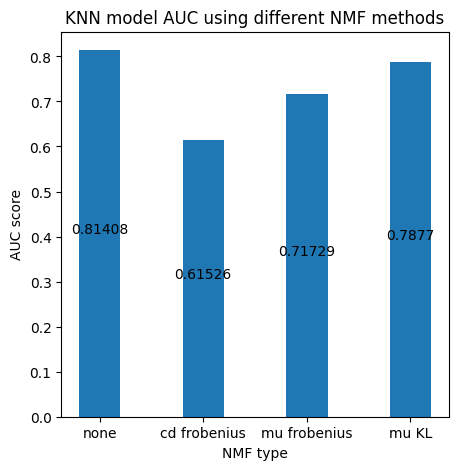

In [239]:
data = {'none':kNN_unscaled_prediction_roc_auc_score, 
        'cd frobenius':kNN_NMF_cd_frobenius_prediction_roc_auc_score, 
        'mu frobenius':kNN_NMF_mu_frobenius_prediction_roc_auc_score,
       'mu KL':kNN_NMF_mu_KL_prediction_roc_auc_score}
models = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(models, values, width = 0.4)

addlabels(models, values)

plt.xlabel("NMF type")
plt.ylabel("AUC score")
plt.title("KNN model AUC using different NMF methods")
plt.show()

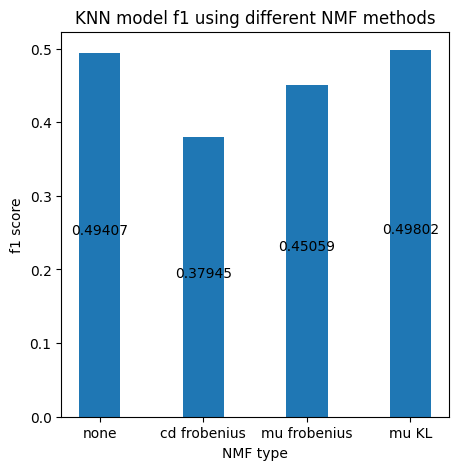

In [240]:
data = {'none':kNN_unscaled_prediction_f1_score, 
        'cd frobenius':kNN_NMF_cd_frobenius_prediction_f1_score, 
        'mu frobenius':kNN_NMF_mu_frobenius_prediction_f1_score,
       'mu KL':kNN_NMF_mu_KL_prediction_f1_score}
models = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(models, values, width = 0.4)

addlabels(models, values)

plt.xlabel("NMF type")
plt.ylabel("f1 score")
plt.title("KNN model f1 using different NMF methods")
plt.show()

Both metrics seems to agree that the Kullback-Leibler loss NMF is best at preserving information that can then be used by the KNN model. 

In fact if we look at the micro f1 score of the KNN model fit on the Kullback-Leibler loss NMF, the f1 score actually improved from dimensionality reduction. 

#### scaled data (for PCA)

In [243]:
kNN_scaled_prediction_proba = kNN_scaled_Grid.best_estimator_.predict_proba(scaled_test)
kNN_scaled_prediction = kNN_scaled_Grid.best_estimator_.predict(scaled_test)

kNN_scaled_prediction_roc_auc_score = roc_auc_score(scaled_label_test, kNN_scaled_prediction_proba, multi_class = 'ovr')

kNN_scaled_prediction_f1_score = f1_score(scaled_label_test, kNN_scaled_prediction, average = 'micro')

In [247]:
kNN_pca_prediction_proba = kNN_pca_Grid.best_estimator_.predict_proba(eight_component_test)
kNN_pca_prediction = kNN_pca_Grid.best_estimator_.predict(eight_component_test)

kNN_pca_prediction_roc_auc_score = roc_auc_score(eight_component_label_test, kNN_pca_prediction_proba, multi_class = 'ovr')

kNN_pca_prediction_f1_score = f1_score(eight_component_label_test, kNN_pca_prediction, average = 'micro')

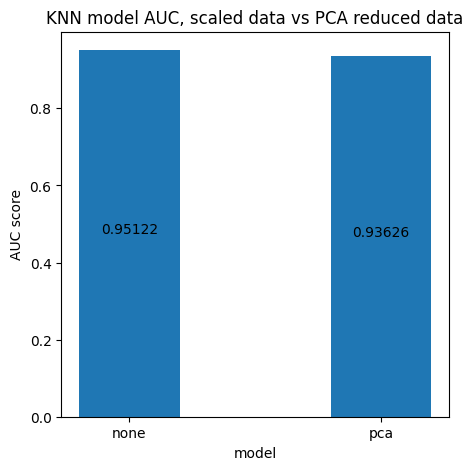

In [252]:
data = {'none':kNN_scaled_prediction_roc_auc_score, 
        'pca':kNN_pca_prediction_roc_auc_score
       }
models = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(models, values, width = 0.4)

addlabels(models, values)

plt.xlabel("model")
plt.ylabel("AUC score")
plt.title("KNN model AUC, scaled data vs PCA reduced data")
plt.show()

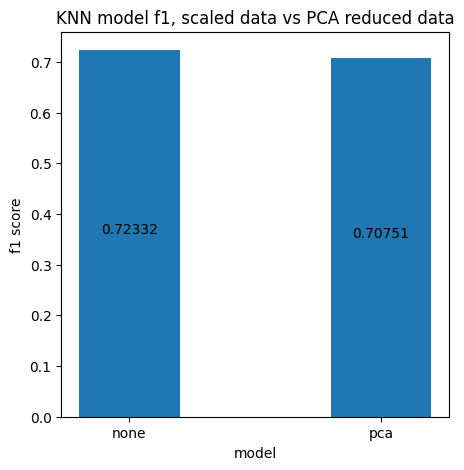

In [251]:
data = {'none':kNN_scaled_prediction_f1_score, 
        'pca':kNN_pca_prediction_f1_score
       }
models = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(models, values, width = 0.4)

addlabels(models, values)

plt.xlabel("model")
plt.ylabel("f1 score")
plt.title("KNN model f1, scaled data vs PCA reduced data")
plt.show()

For both of these metrics, our model fed with the PCA reduced data did perform slightly worse than the model fed with the unreduced original data. But not worst by all that much. 

### Comparing supervised learning and unsupervised learning for predicting the various anemia types

In [307]:
SVC_model_prediction_f1_score = f1_score(scaled_label_test, SVC_model_prediction, average = 'micro')

GBM_model_prediction_f1_score = f1_score(scaled_label_test, GBM_model_prediction, average='micro')

NB_model_prediction_f1_score = f1_score(unscaled_label_test, NB_model_prediction, average='micro')

QDA_model_prediction_f1_score = f1_score(scaled_label_test, QDA_model_prediction, average='micro')

kNN_model_prediction_f1_score = kNN_scaled_prediction_f1_score

HC_model_prediction_f1_score = 0.47901821060965954

NMF_model_prediction_f1_score = 0.29612034837688045

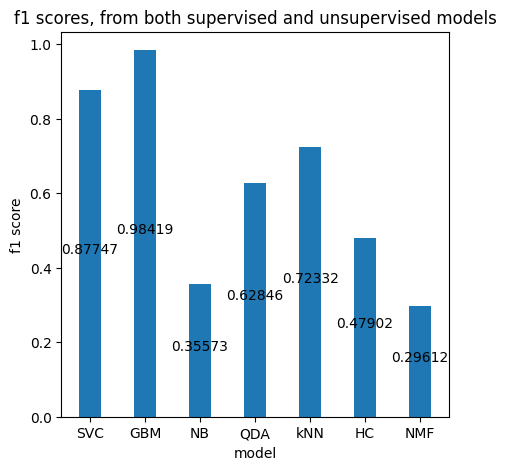

In [308]:
data = {'SVC':SVC_model_prediction_f1_score, 
        'GBM':GBM_model_prediction_f1_score, 
        'NB':NB_model_prediction_f1_score,
        'QDA':QDA_model_prediction_f1_score,
        'kNN':kNN_model_prediction_f1_score,
        'HC':HC_model_prediction_f1_score,
        'NMF':NMF_model_prediction_f1_score
       }
models = list(data.keys())
values = list(data.values())
 
fig = plt.figure(figsize = (5, 5))

# creating the bar plot
plt.bar(models, values, width = 0.4)

addlabels(models, values)

plt.xlabel("model")
plt.ylabel("f1 score")
plt.title("f1 scores, from both supervised and unsupervised models")
plt.show()

We can see here that the performance of the unsupervised models are very poor. 

In general for f1 scores anything below 0.5 is poor, that includes Naive Bayes, hierarchical clustering, and NMF. QDA and KNN performed okay. SVC performed well and GBM performed almost perfectly. 

In another note, what i also noticed is that when i change the tuning parameter to f1 score, my k number for the best model changed quite a bit for the kNN model. There is an improvement in the f1 score of the kNN model but not enough to make it better than the SVC model. And since the other supervised models are tuned with AUC values I figure good idea to keep it the same to be fair. 

## Discussion and takeaways

#### What didn't work:

We see that unsupervised learning models generally don't perform well in this dataset. As well as supervised models that assume that the distribution of each feature is unimodal (QDA) and/or that the distribution of each feature is independent (Naive Bayes). 

What this tells me is that there are larger underlying structures of the data that has nothing to do with the type of anemia a person has. Perhaps the unsupervised models are picking up things like the underlying demographics of the partients rather than the type of condition they have. That probably determines a patient's blood works results more than the type of anemia they have. 

As a result I can see why that unsupervised models would not work well when it comes to separating the different types of anemia. 

#### What worked:

Using unsupervised techniques for dimensionality reduction seems to work decently well. Our f1 score reduction is low when we use dimensionality reduction on our data. 

#### Future directions and improvement:

Since this data didn't contain the underlying patient demographics information I have no way of verifying or testing this. But perhaps if we had information in that we could see what our unsupervised techniques are picking up on in the data. 